In [2]:
# pwd is /content
cd /content/drive/"My Drive"/deep-learning-v2-pytorch/intro-to-pytorch

/content/drive/My Drive/deep-learning-v2-pytorch/intro-to-pytorch


In [0]:
! du -hs Cat_Dog_data

379M	Cat_Dog_data


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import helper

In [0]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30), transforms.RandomResizedCrop(224), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms =transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
model = models.densenet121(pretrained = True )
#switch of gradient
for params in model.parameters():
  params.requires_grad = False

MyClassifier = nn.Sequential( 
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim = 1)
)
#gradient will be only calculated on classifier layer
model.classifier = MyClassifier

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [9]:
model.cuda()

loss_fun = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01 )

epoches = 1
running_loss = 0

train_losses, test_losses = [], []
for e in range(0, epoches):
  steps = 0
  for images, labels in trainloader:
    steps = steps + 1
    images, labels = images.to(device = 'cuda'), labels.to(device = 'cuda')
    optimizer.zero_grad()
    res = model(images)
    loss = loss_fun(res, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if steps % 5 == 0 :
      model.eval()
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        for images, labels in testloader:
          images, labels = images.to(device = 'cuda'), labels.to(device = 'cuda')
          res = model(images)
          loss = loss_fun(res, labels)
          test_loss += loss.item()
          # Calculate accuracy
          ps = torch.exp(res)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      model.train()
      print(steps,"Train loss:", round(running_loss/5,2), "Test loss", round(test_loss / len(testloader),2), "Acc:", round( ( accuracy / len(testloader) ) * 100,2))
      train_losses.append(running_loss / 5)
      test_losses.append(test_loss / len(testloader))
      running_loss = 0
    

190 Train loss: 0.22 Test loss 0.11 Acc: 97.03
195 Train loss: 0.18 Test loss 0.11 Acc: 97.03
200 Train loss: 0.19 Test loss 0.11 Acc: 96.91
205 Train loss: 0.17 Test loss 0.11 Acc: 96.99
210 Train loss: 0.19 Test loss 0.12 Acc: 96.37
215 Train loss: 0.15 Test loss 0.11 Acc: 96.95
220 Train loss: 0.23 Test loss 0.11 Acc: 96.45
225 Train loss: 0.17 Test loss 0.09 Acc: 97.54
230 Train loss: 0.17 Test loss 0.1 Acc: 97.07
235 Train loss: 0.15 Test loss 0.1 Acc: 97.19


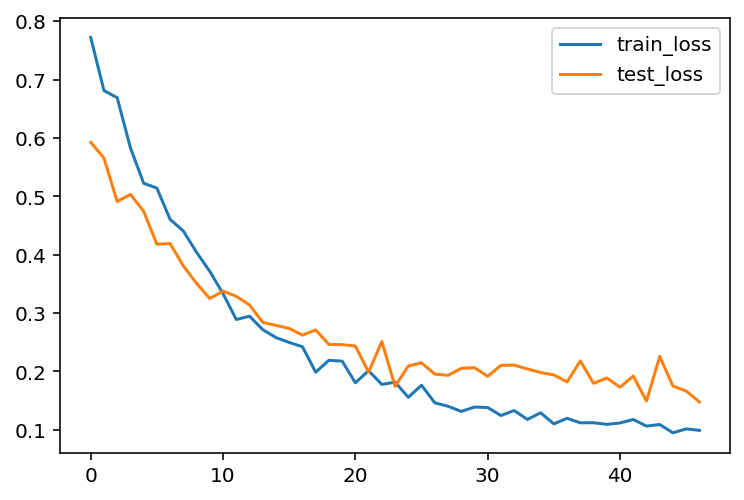

In [10]:
import matplotlib.pyplot as plt
plt.plot(test_losses, label="train_loss")
plt.plot(train_losses, label = "test_loss")
plt.legend()
plt.show()

In [0]:
torch.save(model.state_dict(), 'cdict.pt')